In [9]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import nltk
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score
import re
from collections import OrderedDict
from gensim.models import Word2Vec, KeyedVectors
from gensim.matutils import unitvec
from whatlies import EmbeddingSet, Embedding
from whatlies.transformers import Normalizer, Tsne
from sklearn.manifold import TSNE
import pickle
import collections
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [10]:
# Import dataset
characters_df = pd.read_csv("./dataset/Characters.csv", sep=";")
movie1_df = pd.read_csv("./dataset/Harry Potter 1.csv", sep=";")
movie2_df = pd.read_csv("./dataset/Harry Potter 2.csv", sep=";")
movie3_df = pd.read_csv("./dataset/Harry Potter 3.csv", sep=";")
potions_df = pd.read_csv("./dataset/Potions.csv", sep=";")
other_characters_df = pd.read_csv("./dataset/shortversioncharacters.csv", sep=",")
spells_df = pd.read_csv("./dataset/Spells.csv", sep=";")

In [11]:
# Analyze characters
class Character():
    def __init__(self, df):
        self.data = df
        f = open("./resources/character_mapping.json", "r")
        self.character_mapping = json.load(f)
        f.close()
        
    def map(self, character_name):
        # Map similar character to a group
        if character_name in self.character_mapping and self.character_mapping[character_name] is not None:
            return self.character_mapping[character_name].title()
        else:
            return character_name.title()

In [12]:
# Movie
movie1_df['Movie'] = 'Harry Potter and the Sorcerers Stone'
movie2_df['Movie'] = 'Harry Potter and the Chamber of Secrets'
movie3_df['Movie'] = 'Harry Potter and the Prisoner of Azkaban'

movies_list = [movie1_df, movie2_df, movie3_df]

class Movie():
    def __init__(self, df: list):
        self.movie_list = df
        self.movies_df = self.combine_movies()

    def combine_movies(self):
        # Combine movies
        for i in self.movie_list:
            i.columns = map(str.title, i.columns)
        
        return pd.concat([movie1_df, movie2_df, movie3_df], ignore_index=False)
        
    def preprocess(self):
        # Strip the spaces in character to remove identifying the same character twice
        self.movies_df["Character"] = self.movies_df.apply(lambda row: row["Character"].strip().title(), axis=1)


In [13]:
# Preprocess
def preprocessing():
    c = Character(characters_df)
    
    m = Movie(movies_list)
    m.preprocess()
    
    for i, j in m.movies_df.iterrows():
        j["Character"] = c.map(j["Character"])

    return c,m

c, m = preprocessing()

In [14]:
grouped = m.movies_df.groupby("Character").count().reset_index()
grouped.sort_values('Sentence', ascending=False)

,Character,Sentence,Movie
41,Harry,1028,1028
78,Ron,536,536
44,Hermione,485,485
40,Hagrid,394,394
21,Dumbledore,239,239
...,...,...,...
86,Slytherins,1,1
13,Cornish Pixies,1,1
69,Parvati,1,1
70,Penelope Clearwater,1,1


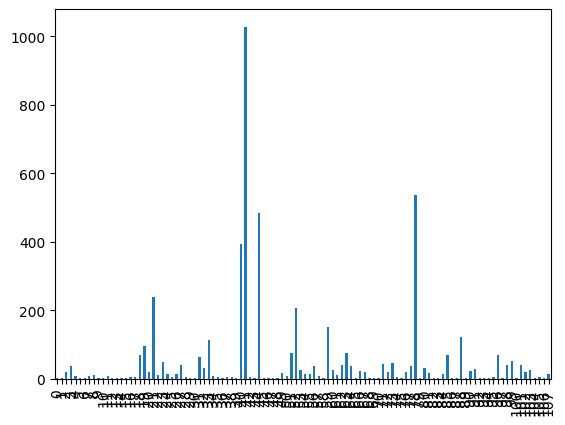

In [15]:
# create histograms for length of total script
def plotLengethOfTotalScript(df):
    # grouped.plot(kind='bar')
    pd.Series(grouped["Sentence"]).plot(kind='bar')

plotLengethOfTotalScript(m.movies_df)

In [82]:
# Combine sentences for each character
combined_sentences = m.movies_df.groupby('Character')['Sentence'].apply(' '.join).reset_index()

#Add columns for Vocabulary, vocabulary size, unique words (mentioned one time) ans most frequent words
combined_sentences['vocabulary'] = None
combined_sentences['vocabulary_size'] = None
combined_sentences['words_mentioned_once'] = None
combined_sentences['most_frequent_words'] = None
combined_sentences['words_mentioned_once_size'] = None

In [17]:
def PreProcessToCombinedSentences(words):
    StopWords=stopwords.words('english')
    words = [word for word in words if word not in StopWords]
    
    return words

In [89]:
def generate_Vocabulary_UniqueWords_WordsFrequency(combined_sentences) :

    for index, row in combined_sentences.iterrows():
        character = row['Character']
        sentences = row['Sentence']

        # sentences = PreProcessToRemoveDelimetersAndNumbers(sentences)
        # Tokenize the text into words
        words = nltk.word_tokenize(sentences)  
        words = [word.lower() for word in words if word.isalpha()]
        
        # Create a vocabulary (set of unique words)
        vocabulary = set(words)
    
        # Convert the set back to a sorted list if needed
        vocabulary_list = sorted(list(vocabulary))
    
        combined_sentences.at[index, 'vocabulary']=vocabulary_list
    
        # Calculate vocabulary size (total unique words)
        vocabulary_size = len(set(vocabulary))
    
        # row['vocabulary_size']==vocabulary_size
        combined_sentences.at[index, 'vocabulary_size'] = vocabulary_size
        
        words = PreProcessToCombinedSentences(words)
    
        # Create a word frequency dictionary
        word_frequency = Counter(words)
    
        # Find words mentioned only once
        words_mentioned_once = [word for word, freq in word_frequency.items() if freq == 1]
        combined_sentences.at[index, 'words_mentioned_once']=words_mentioned_once
        combined_sentences.at[index, 'words_mentioned_once_size']=len(words_mentioned_once)
    
        # Find the thirty most frequent words
        most_frequent_words_list = word_frequency.most_common(30)
        # Extract the words from the list of tuples
        most_frequent_words = [word for word, count in most_frequent_words_list]
        combined_sentences.at[index, 'most_frequent_words']=most_frequent_words


In [90]:
generate_Vocabulary_UniqueWords_WordsFrequency(combined_sentences)

In [20]:
#Display the result
print(combined_sentences['vocabulary'])

0                                        [ahhhhhhh, yay]
1                [about, know, sorcerer, stone, the, we]
2      [a, above, accused, all, an, ancient, and, any...
3      [a, about, actually, all, an, and, are, at, ba...
4      [arrive, did, door, for, graciously, harry, he...
                             ...                        
103    [a, again, all, and, another, arrrhhhhhh, ask,...
104                                      [harry, potter]
105    [are, at, back, believe, ca, come, crockford, ...
106                 [anything, dears, off, the, trolley]
107    [a, all, and, believe, booked, ca, cancel, cha...
Name: vocabulary, Length: 108, dtype: object


In [21]:
print(combined_sentences['vocabulary_size'])

0        2
1        6
2       83
3      118
4       32
      ... 
103     97
104      2
105     30
106      5
107     71
Name: vocabulary_size, Length: 108, dtype: object


In [22]:
print(combined_sentences['words_mentioned_once'])

0                                        [ahhhhhhh, yay]
1                                [know, sorcerer, stone]
2      [yes, sent, men, hollow, lie, opened, chamber,...
3      [still, ungrateful, way, damn, brother, keep, ...
4      [pupkins, masons, arrive, lounge, waiting, wel...
                             ...                        
103    [use, boy, let, speak, strength, potter, meet,...
104                                      [harry, potter]
105    [doris, crockford, mr, potter, ca, believe, me...
106                           [anything, trolley, dears]
107    [spent, summer, devising, whole, program, gon,...
Name: words_mentioned_once, Length: 108, dtype: object


In [23]:
print(combined_sentences['most_frequent_words'])

0                                        [ahhhhhhh, yay]
1                                [know, sorcerer, stone]
2      [hagrid, never, castle, yes, sent, men, hollow...
3      [boy, vernon, little, petunia, something, say,...
4      [harry, oh, pupkins, masons, arrive, lounge, w...
                             ...                        
103    [harry, see, something, lies, enough, live, gi...
104                                      [harry, potter]
105    [doris, crockford, mr, potter, ca, believe, me...
106                           [anything, trolley, dears]
107    [new, quidditch, train, today, professor, seek...
Name: most_frequent_words, Length: 108, dtype: object


In [24]:
combined_sentences.sort_values('vocabulary_size', ascending=False).head(50)

,Character,Sentence,vocabulary,vocabulary_size,words_mentioned_once,most_frequent_words
41,Harry,"Yes, Aunt Petunia. Yes, Uncle Vernon. He's asl...","[a, about, accepted, accidentally, according, ...",970,"[aunt, petunia, watching, press, ugly, often, ...","[ron, hagrid, come, know, go, get, think, herm..."
44,Hermione,Has anyone seen a toad? A boy named Neville's ...,"[a, able, about, accident, according, add, aft...",751,"[toad, named, magic, spell, tried, ones, examp...","[harry, ron, go, come, one, ca, got, going, co..."
78,Ron,Excuse me. Do you mind? Everywhere else is ful...,"[a, aaa, aboard, about, across, actually, afte...",749,"[excuse, everywhere, full, set, every, flavor,...","[harry, go, think, got, know, hermione, one, r..."
21,Dumbledore,"I should've known that you would be here, Prof...","[a, abilities, able, about, account, across, a...",703,"[bad, bringing, problems, albus, leaving, peop...","[harry, professor, well, would, hagrid, points..."
40,Hagrid,"Professor Dumbledore, sir. Professor McGonagal...","[a, about, absolutely, according, acne, across...",675,"[mcgonagall, tyke, fell, asleep, flying, brist...","[harry, well, come, go, right, dumbledore, pro..."
52,Lupin,"Here, eat this. It'll help. It's all right. It...","[a, about, absolutely, actually, advanced, aff...",496,"[help, chocolate, guards, azkaban, gone, searc...","[harry, well, good, yes, much, see, come, memo..."
59,Mcgonagall,"Good evening, Professor Dumbledore. Are the ru...","[a, able, about, according, actions, admitted,...",464,"[rumors, wise, hagrid, important, watched, sor...","[potter, weasley, slytherin, school, professor..."
88,Snape,There will be no foolish wand-waving or silly ...,"[a, abilities, about, aconite, added, after, a...",430,"[foolish, incantations, class, expect, many, a...","[potter, one, werewolf, would, well, turn, tim..."
33,Gilderoy Lockhart,Let me introduce you to your new Defense Again...,"[a, about, accidents, adventure, afraid, again...",362,"[new, arts, teacher, gilderoy, lockhart, order...","[harry, well, professor, let, know, see, round..."
96,Tom Riddle,"Professor Dumbledore. Yes, professor. I suppos...","[a, able, about, afraid, after, again, against...",295,"[suppose, rumors, true, well, home, really, st...","[hagrid, would, ginny, dumbledore, wo, knew, v..."


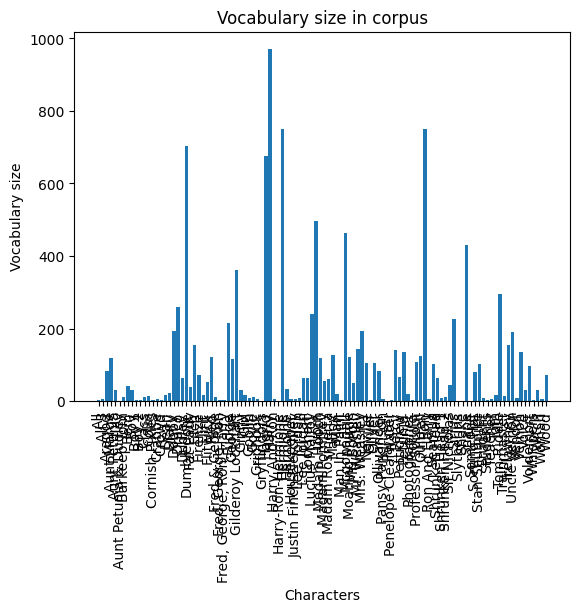

<Figure size 3000x2300 with 0 Axes>

In [25]:
# create histograms for vocabulary size of characters
def plotVocabularySizeOfCharacters(df):
    # pd.Series(df['vocabulary_size']).plot(kind='bar')
    plt.bar(df['Character'].tolist(), df['vocabulary_size'].tolist())
    plt.title("Vocabulary size in corpus")
    plt.ylabel("Vocabulary size")
    plt.xlabel("Characters")
    plt.xticks(rotation='vertical')
    plt.figure(figsize=(30, 23))
    plt.show()

plotVocabularySizeOfCharacters(combined_sentences)

In [97]:
combined_sentences_50_most_vocabulary=combined_sentences.sort_values('vocabulary_size', ascending=False).reset_index().head(30)

In [92]:
combined_sentences_50_most_vocabulary

,index,Character,Sentence,vocabulary,vocabulary_size,words_mentioned_once,most_frequent_words,words_mentioned_once_size
0,41,Harry,oh yeah must blame one turned let tell stop go...,"[aboard, absolutely, according, across, actual...",889,"[grass, grow, locked, send, blowing, aunts, ma...","[come, harry, go, sirius, know, think, ron, we...",436
1,78,Ron,ancient runes time divination two classes broa...,"[aboard, absolutely, actually, advanced, affec...",661,"[future, treat, today, great, lesson, group, s...","[harry, well, go, come, got, good, scabbers, h...",373
2,44,Hermione,let make first move polite step give nice bow ...,"[according, across, affect, age, ago, alive, a...",591,"[polite, step, bow, brute, pat, shy, smoke, ne...","[harry, come, go, well, ron, professor, buckbe...",348
3,40,Hagrid,nothing school stuff later perhaps behave stil...,"[aboard, accidental, actually, ah, alive, allo...",524,"[school, stuff, perhaps, behave, ungrateful, d...","[well, harry, come, ron, done, buckbeak, know,...",326
4,21,Dumbledore,lumos maxima lumos maxima harry harry marge lo...,"[act, activities, actually, administered, afte...",462,"[lovely, straight, orphanage, dumped, doorstep...","[harry, come, time, one, like, know, well, see...",341
5,52,Lupin,eat help right chocolate dementor one guards a...,"[absolutely, actually, advanced, affect, age, ...",412,"[help, chocolate, guards, azkaban, gone, searc...","[harry, well, good, yes, much, see, come, memo...",295
6,88,Snape,sorry potter final word forget guys see later ...,"[ago, also, animagus, antidote, anywhere, appo...",313,"[sorry, final, forget, guys, later, ask, somet...","[potter, one, werewolf, turn, yes, take, think...",257
7,59,Mcgonagall,lumos maxima lumos maxima harry open door uncl...,"[ago, also, always, animagus, another, anywher...",271,"[open, door, uncle, vernon, need, dudders, giv...","[black, sirius, well, potter, come, one, harry...",175
8,19,Draco,first year yes sit kill mean blow lost control...,"[absolutely, actually, always, announce, anoth...",259,"[first, year, sit, kill, blow, control, brilli...","[sirius, black, think, come, see, yes, time, e...",208
9,33,Gilderoy Lockhart,away silly creature killed calm scratch hagrid...,"[ago, allowed, also, always, another, anyone, ...",203,"[silly, creature, calm, scratch, taken, hospit...","[come, get, see, good, thick, black, wonderful...",153


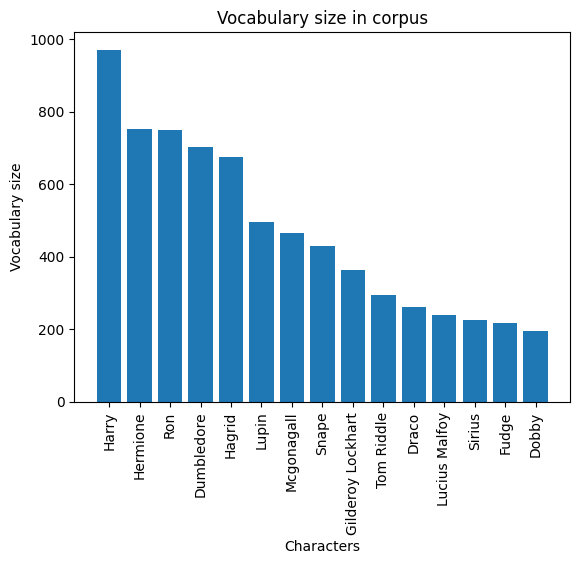

<Figure size 3000x2300 with 0 Axes>

In [28]:
plotVocabularySizeOfCharacters(combined_sentences_50_most_vocabulary)

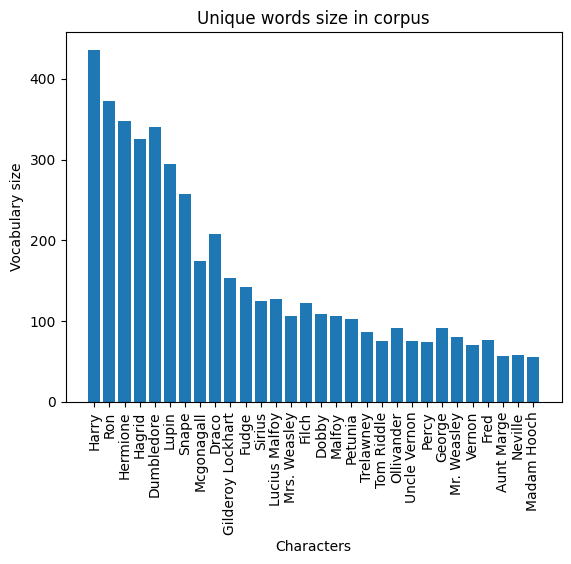

<Figure size 3000x2300 with 0 Axes>

In [99]:
# create histograms for unique words size of characters
def plotVocabularySizeOfCharacters(df):
    # pd.Series(df['vocabulary_size']).plot(kind='bar')
    plt.bar(df['Character'].tolist(), df['words_mentioned_once_size'].tolist())
    plt.title("Unique words size in corpus")
    plt.ylabel("Vocabulary size")
    plt.xlabel("Characters")
    plt.xticks(rotation='vertical')
    plt.figure(figsize=(30, 23))
    plt.show()

plotVocabularySizeOfCharacters(combined_sentences_50_most_vocabulary)

In [29]:
combined_sentences_50_most_vocabulary['most_frequent_words']

0     [ron, hagrid, come, know, go, get, think, herm...
1     [harry, ron, go, come, one, ca, got, going, co...
2     [harry, go, think, got, know, hermione, one, r...
3     [harry, professor, well, would, hagrid, points...
4     [harry, well, come, go, right, dumbledore, pro...
5     [harry, well, good, yes, much, see, come, memo...
6     [potter, weasley, slytherin, school, professor...
7     [potter, one, werewolf, would, well, turn, tim...
8     [harry, well, professor, let, know, see, round...
9     [hagrid, would, ginny, dumbledore, wo, knew, v...
10    [potter, father, time, see, one, mudblood, wel...
11    [well, potter, course, ministry, come, draco, ...
12    [remus, know, come, run, kill, rat, james, har...
13    [hagrid, come, well, business, yes, harry, oh,...
14    [dobby, harry, potter, sir, ho, bad, oh, ha, m...
Name: most_frequent_words, dtype: object

In [30]:
combined_sentences_50_most_vocabulary['words_mentioned_once'].head(30)	

0     [aunt, petunia, watching, press, ugly, often, ...
1     [toad, named, magic, spell, tried, ones, examp...
2     [excuse, everywhere, full, set, every, flavor,...
3     [bad, bringing, problems, albus, leaving, peop...
4     [mcgonagall, tyke, fell, asleep, flying, brist...
5     [help, chocolate, guards, azkaban, gone, searc...
6     [rumors, wise, hagrid, important, watched, sor...
7     [foolish, incantations, class, expect, many, a...
8     [new, arts, teacher, gilderoy, lockhart, order...
9     [suppose, rumors, true, well, home, really, st...
10    [wingardium, fault, teachers, favorites, hermi...
11    [buying, today, selling, heard, magic, conduct...
12    [well, madness, within, found, enough, waiting...
13    [three, attacks, gone, far, enough, act, albus...
14    [honor, house, elf, understands, tell, difficu...
Name: words_mentioned_once, dtype: object

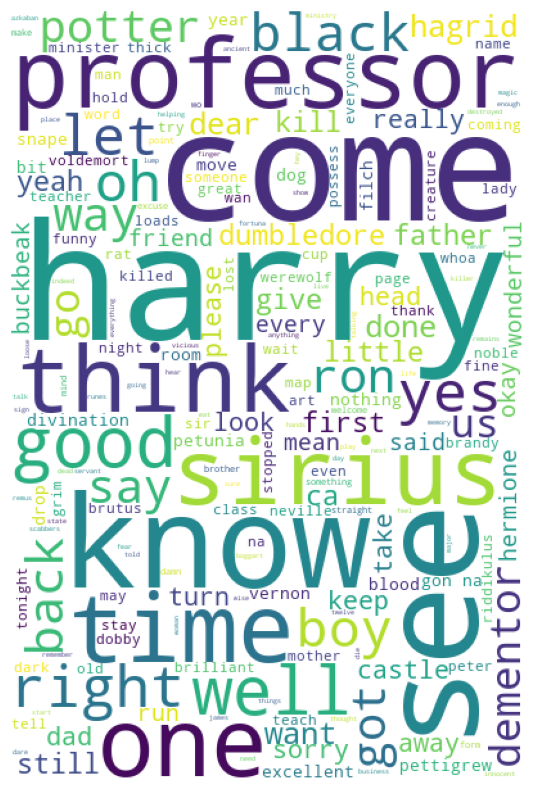

In [110]:
text = ' '.join(word for wordlist in combined_sentences_50_most_vocabulary['most_frequent_words'] for word in wordlist)
wc = WordCloud(
    background_color='white',
    max_words=200,
    height=600,
    width=400,
).generate(text)

plt.figure(figsize=(10,10))
# plt.title('Most fequent words in each character', 
#           fontdict={'size': 10,  'verticalalignment': 'center'})
plt.imshow(wc)
plt.axis("off")
plt.show()

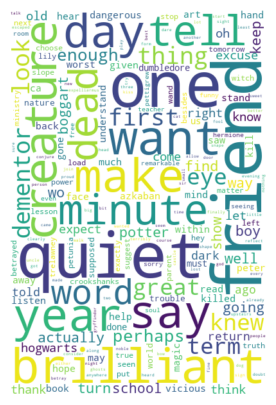

In [106]:
text = ' '.join(word for wordlist in combined_sentences_50_most_vocabulary['words_mentioned_once'] for word in wordlist)
wc = WordCloud(
    background_color='white',
    max_words=200,
    height=600,
    width=400,
).generate(text)

plt.figure(figsize=(10,5))
# plt.title('Words mentioned once in the corpus', 
#           fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [33]:
def SimilarityMatrixByCommonWords(characters, word_lists):
    text = [" ".join(word_list) for word_list in word_lists]
    # Initialize a CountVectorizer to convert text to a bag of words
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(text)
    
    # Create a character-to-character Jaccard similarity matrix
    character_names = characters.tolist()
    similarity_matrix = []

    #Similarity by common words
    for i in range(len(character_names)):
        row = []
        for j in range(len(character_names)):
            if i == j:
                similarity = 1.0  # Similarity with oneself is 1.0
            else:
                set1 = set(X[i].indices)
                set2 = set(X[j].indices)
                intersection = len(set1.intersection(set2))
                union = len(set1) + len(set2) - intersection
                if union == 0:
                    similarity = 0

                else :
                    similarity = intersection / union
            row.append(similarity)
        similarity_matrix.append(row)

    #Matrix
    similarity_df = pd.DataFrame(similarity_matrix, columns=character_names, index=character_names)    

    return similarity_df

In [34]:
def CharacterToCharacterMatrixPlot(characters, matrix):
    character_names = characters.tolist()
    # Plot the character-to-character matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.xticks(range(len(character_names)), character_names, rotation='vertical')
    plt.yticks(range(len(character_names)), character_names)
    plt.title('Character-to-Character Matrix')
    plt.show()

In [35]:
def mostCommonPairs(characters, matrix, number) :
    character_names = characters.tolist()
    most_common_pairs = []
    for index, character1 in enumerate(character_names):
        for character2 in character_names[index:]:
            if character1 != character2:
                count = matrix.at[character1, character2]
                most_common_pairs.append((character1, character2, count))
    
    # Sort the list of pairs by count in descending order
    most_common_pairs.sort(key=lambda x: x[2], reverse=True)
    
    # Display the most common pairs
    print("Most Common Pairs:")    
    for x in range(number):
        print(f"{most_common_pairs[x][0]} and {most_common_pairs[x][1]}: {most_common_pairs[x][2]} Similarity")

In [36]:
#Character To Character Matrix for the Similarity of each Character By Using the Common Words in the Vocabulary
similarity_df = SimilarityMatrixByCommonWords(combined_sentences['Character'], combined_sentences['vocabulary'])

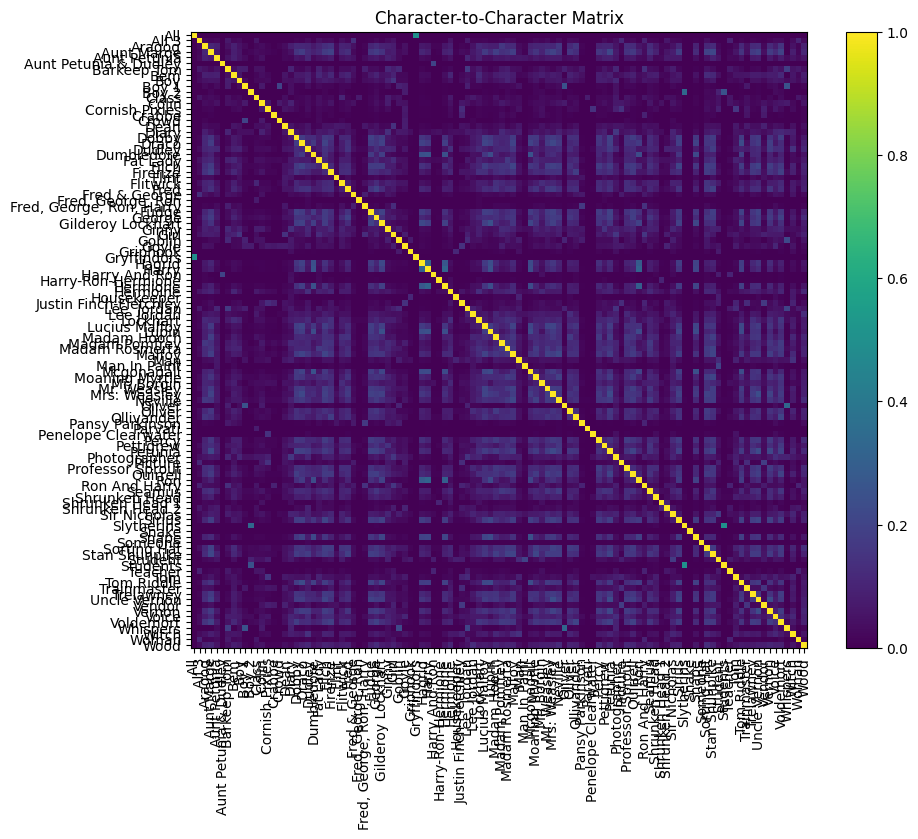

In [37]:
#Plot the matrix
CharacterToCharacterMatrixPlot(combined_sentences['Character'], similarity_df)

In [38]:
#Most 30 common paris
mostCommonPairs(combined_sentences['Character'], similarity_df, 30)

Most Common Pairs:
All and Gryffindors: 0.5 Similarity
Slytherins and Students: 0.5 Similarity
Boy 2 and Slytherins: 0.3333333333333333 Similarity
Oiiver and Whispers: 0.3333333333333333 Similarity
Harry and Hermione: 0.3199691595990748 Similarity
Harry and Ron: 0.31790123456790126 Similarity
Hagrid and Harry: 0.31219903691813805 Similarity
Hermione and Ron: 0.3002610966057441 Similarity
Hagrid and Ron: 0.28701180744777477 Similarity
Hagrid and Hermione: 0.2721575649059982 Similarity
Dumbledore and Harry: 0.256797583081571 Similarity
Dumbledore and Mcgonagall: 0.2518837459634015 Similarity
Boy 1 and Oiiver: 0.25 Similarity
Boy 1 and Whispers: 0.25 Similarity
Boy 2 and Students: 0.25 Similarity
Harry and Lupin: 0.24636441402908468 Similarity
Dumbledore and Hagrid: 0.24478694469628287 Similarity
Mcgonagall and Snape: 0.24475524475524477 Similarity
Gilderoy Lockhart and Lupin: 0.2430858806404658 Similarity
Dumbledore and Hermione: 0.24250214224507283 Similarity
Hagrid and Lupin: 0.2417465

In [39]:
#Character To Character Matrix for the Similarity of each Character By Using the Common Words in the Unique words of each character
similarity_unique_words_df = SimilarityMatrixByCommonWords(combined_sentences['Character'], combined_sentences['words_mentioned_once'])

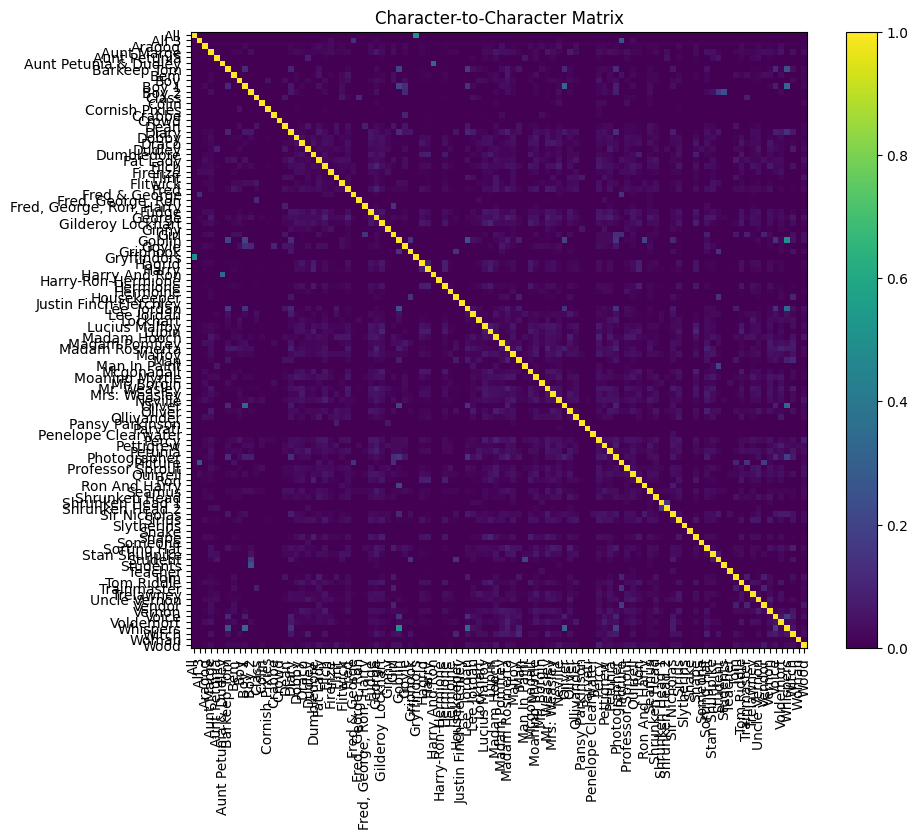

In [40]:
#Plot the matrix
CharacterToCharacterMatrixPlot(combined_sentences['Character'], similarity_unique_words_df)

In [41]:
#Most common pairs
mostCommonPairs(combined_sentences['Character'], similarity_unique_words_df, 30)

Most Common Pairs:
All and Gryffindors: 0.5 Similarity
Goblin and Whispers: 0.5 Similarity
Aunt Petunia & Dudley and Harry And Ron: 0.3333333333333333 Similarity
Boy 1 and Oiiver: 0.3333333333333333 Similarity
Boy 1 and Whispers: 0.3333333333333333 Similarity
Lee  Jordan and Whispers: 0.3333333333333333 Similarity
Oiiver and Whispers: 0.3333333333333333 Similarity
All 3 and Picture: 0.25 Similarity
Barkeep Tom and Whispers: 0.25 Similarity
Boy 2 and Students: 0.25 Similarity
Goblin and Lee  Jordan: 0.25 Similarity
Barkeep Tom and Goblin: 0.2 Similarity
Boy 1 and Goblin: 0.2 Similarity
Goblin and Oiiver: 0.2 Similarity
Goblin and Ron And Harry: 0.2 Similarity
Man In Paint and Student: 0.2 Similarity
Photographer and Whispers: 0.18181818181818182 Similarity
Barkeep Tom and Lee  Jordan: 0.16666666666666666 Similarity
Boy 2 and Student: 0.16666666666666666 Similarity
Picture and Vendor: 0.16666666666666666 Similarity
Voice and Whispers: 0.16666666666666666 Similarity
Goblin and Photographe

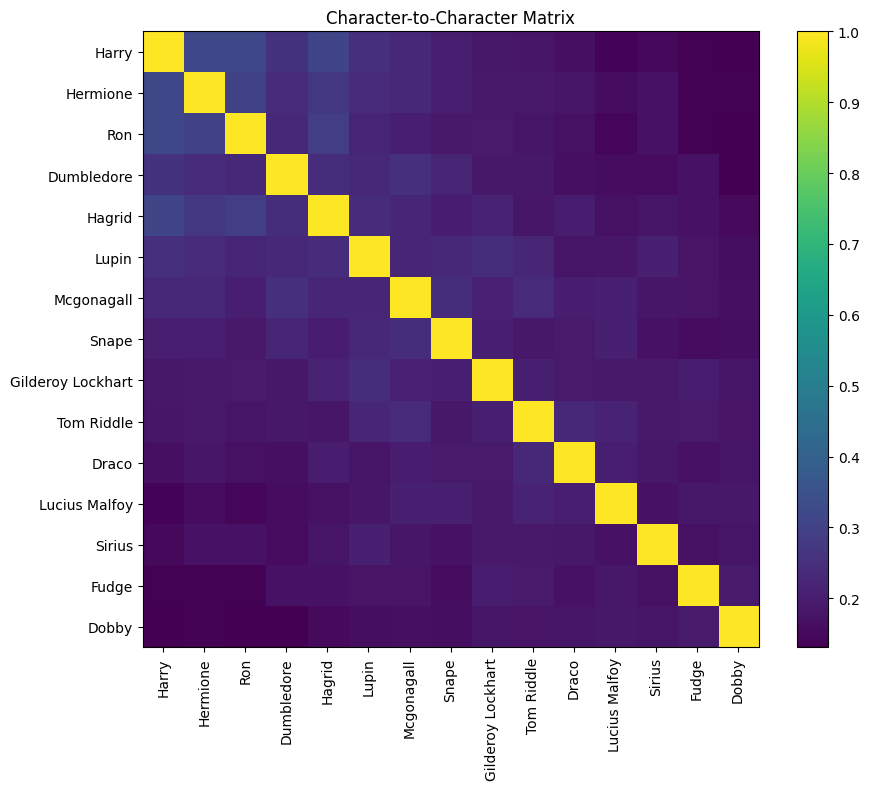

In [42]:
#Character To Character Matrix for the Similarity of each Character By Using the Common Words in the Vocabulary
similarity_df_50_most_vocabulary = SimilarityMatrixByCommonWords(combined_sentences_50_most_vocabulary['Character'], combined_sentences_50_most_vocabulary['vocabulary'])

#Plot the matrix
CharacterToCharacterMatrixPlot(combined_sentences_50_most_vocabulary['Character'], similarity_df_50_most_vocabulary)

In [43]:
similarity_df_50_most_vocabulary

,Harry,Hermione,Ron,Dumbledore,Hagrid,Lupin,Mcgonagall,Snape,Gilderoy Lockhart,Tom Riddle,Draco,Lucius Malfoy,Sirius,Fudge,Dobby
Harry,1.000000,0.319969,0.317901,0.256798,0.312199,0.246364,0.229508,0.203287,0.185484,0.183789,0.164919,0.139601,0.150194,0.137198,0.132613
Hermione,0.319969,1.000000,0.300261,0.242502,0.272158,0.236816,0.225709,0.204708,0.191192,0.189498,0.184489,0.158637,0.172289,0.135613,0.136804
Ron,0.317901,0.300261,1.000000,0.230638,0.287012,0.219488,0.202191,0.189655,0.192017,0.178207,0.168801,0.141860,0.171705,0.136256,0.130593
Dumbledore,0.256798,0.242502,0.230638,1.000000,0.244787,0.231959,0.251884,0.221861,0.186801,0.187575,0.166464,0.160891,0.154806,0.174583,0.132147
Hagrid,0.312199,0.272158,0.287012,0.244787,1.000000,0.241747,0.223301,0.195652,0.216981,0.182598,0.195122,0.169884,0.180501,0.171958,0.153949
Lupin,0.246364,0.236816,0.219488,0.231959,0.241747,1.000000,0.225641,0.226064,0.243086,0.223950,0.180251,0.182848,0.206723,0.176080,0.161290
Mcgonagall,0.229508,0.225709,0.202191,0.251884,0.223301,0.225641,1.000000,0.244755,0.210604,0.233660,0.195688,0.207254,0.184801,0.175652,0.166369
Snape,0.203287,0.204708,0.189655,0.221861,0.195652,0.226064,0.244755,1.000000,0.208589,0.187809,0.194783,0.206897,0.172662,0.158845,0.161654
Gilderoy Lockhart,0.185484,0.191192,0.192017,0.186801,0.216981,0.243086,0.210604,0.208589,1.000000,0.207024,0.194981,0.189243,0.189409,0.195833,0.180258
Tom Riddle,0.183789,0.189498,0.178207,0.187575,0.182598,0.223950,0.233660,0.187809,0.207024,1.000000,0.226667,0.218391,0.191244,0.192941,0.178049


In [44]:
#Most 30 common paris
mostCommonPairs(combined_sentences_50_most_vocabulary['Character'], similarity_df_50_most_vocabulary, 30)

Most Common Pairs:
Harry and Hermione: 0.3199691595990748 Similarity
Harry and Ron: 0.31790123456790126 Similarity
Harry and Hagrid: 0.31219903691813805 Similarity
Hermione and Ron: 0.3002610966057441 Similarity
Ron and Hagrid: 0.28701180744777477 Similarity
Hermione and Hagrid: 0.2721575649059982 Similarity
Harry and Dumbledore: 0.256797583081571 Similarity
Dumbledore and Mcgonagall: 0.2518837459634015 Similarity
Harry and Lupin: 0.24636441402908468 Similarity
Dumbledore and Hagrid: 0.24478694469628287 Similarity
Mcgonagall and Snape: 0.24475524475524477 Similarity
Lupin and Gilderoy Lockhart: 0.2430858806404658 Similarity
Hermione and Dumbledore: 0.24250214224507283 Similarity
Hagrid and Lupin: 0.2417465388711395 Similarity
Hermione and Lupin: 0.23681592039800994 Similarity
Mcgonagall and Tom Riddle: 0.23366013071895425 Similarity
Dumbledore and Lupin: 0.23195876288659795 Similarity
Ron and Dumbledore: 0.23063829787234041 Similarity
Harry and Mcgonagall: 0.22950819672131148 Similarit

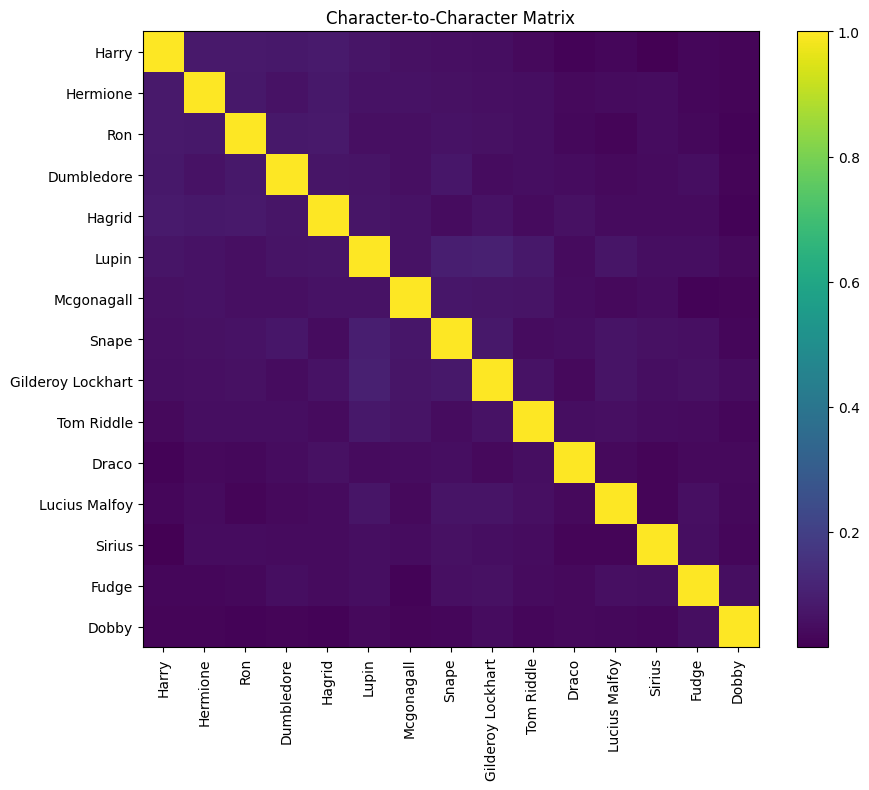

In [45]:
#Character To Character Matrix for the Similarity of each Character By Using the Common Words in the Unique words of each character
similarity_unique_words_df_50_most_vocabulary = SimilarityMatrixByCommonWords(combined_sentences_50_most_vocabulary['Character'], combined_sentences_50_most_vocabulary['words_mentioned_once'])

#Plot the matrix
CharacterToCharacterMatrixPlot(combined_sentences_50_most_vocabulary['Character'], similarity_unique_words_df_50_most_vocabulary)

In [46]:
similarity_unique_words_df_50_most_vocabulary


,Harry,Hermione,Ron,Dumbledore,Hagrid,Lupin,Mcgonagall,Snape,Gilderoy Lockhart,Tom Riddle,Draco,Lucius Malfoy,Sirius,Fudge,Dobby
Harry,1.000000,0.083535,0.082143,0.079042,0.087742,0.070735,0.058993,0.054698,0.050520,0.041868,0.024590,0.031667,0.015177,0.030769,0.028986
Hermione,0.083535,1.000000,0.080051,0.064475,0.076923,0.062593,0.062794,0.059633,0.057096,0.051878,0.040441,0.044776,0.048263,0.034221,0.028283
Ron,0.082143,0.080051,1.000000,0.078086,0.081301,0.055152,0.056575,0.061562,0.057508,0.052448,0.037567,0.030521,0.048964,0.037175,0.023483
Dumbledore,0.079042,0.064475,0.078086,1.000000,0.071913,0.068351,0.055641,0.075385,0.049759,0.053191,0.047619,0.038532,0.043726,0.053640,0.030000
Hagrid,0.087742,0.076923,0.081301,0.071913,1.000000,0.069579,0.064736,0.047386,0.064286,0.042802,0.057613,0.045267,0.044681,0.044586,0.024664
Lupin,0.070735,0.062593,0.055152,0.068351,0.069579,1.000000,0.063340,0.098266,0.100629,0.078886,0.042353,0.071078,0.052632,0.049875,0.040431
Mcgonagall,0.058993,0.062794,0.056575,0.055641,0.064736,0.063340,1.000000,0.074447,0.072368,0.067164,0.046272,0.041558,0.046322,0.026667,0.029412
Snape,0.054698,0.059633,0.061562,0.075385,0.047386,0.098266,0.074447,1.000000,0.076759,0.049528,0.052239,0.066496,0.058201,0.055263,0.030986
Gilderoy Lockhart,0.050520,0.057096,0.057508,0.049759,0.064286,0.100629,0.072368,0.076759,1.000000,0.063830,0.041322,0.065903,0.053412,0.059524,0.049020
Tom Riddle,0.041868,0.051878,0.052448,0.053191,0.042802,0.078886,0.067164,0.049528,0.063830,1.000000,0.052980,0.054054,0.046099,0.045936,0.031621


In [47]:
#Plot the matrix
mostCommonPairs(combined_sentences_50_most_vocabulary['Character'], similarity_unique_words_df_50_most_vocabulary, 30)

Most Common Pairs:
Lupin and Gilderoy Lockhart: 0.10062893081761007 Similarity
Lupin and Snape: 0.09826589595375723 Similarity
Harry and Hagrid: 0.08774193548387096 Similarity
Harry and Hermione: 0.08353510895883777 Similarity
Harry and Ron: 0.08214285714285714 Similarity
Ron and Hagrid: 0.08130081300813008 Similarity
Hermione and Ron: 0.08005082592121983 Similarity
Harry and Dumbledore: 0.07904191616766468 Similarity
Lupin and Tom Riddle: 0.07888631090487239 Similarity
Ron and Dumbledore: 0.07808564231738035 Similarity
Hermione and Hagrid: 0.07692307692307693 Similarity
Snape and Gilderoy Lockhart: 0.0767590618336887 Similarity
Dumbledore and Snape: 0.07538461538461538 Similarity
Mcgonagall and Snape: 0.0744466800804829 Similarity
Mcgonagall and Gilderoy Lockhart: 0.07236842105263158 Similarity
Dumbledore and Hagrid: 0.07191316146540028 Similarity
Lupin and Lucius Malfoy: 0.07107843137254902 Similarity
Harry and Lupin: 0.07073509015256588 Similarity
Hagrid and Lupin: 0.069579288025889

In [49]:
#10
# load histwords as gensim KeyedVectors
def load_historical_embeddings(year, path):
    with open(path + str(year) + "-vocab.pkl", "rb") as f:
        vocab = pickle.load(f)
    np.bool = np.bool_

    vectors = np.load(path + str(year) + "-w.npy", mmap_mode="c")
    
    kv = KeyedVectors(vector_size=vectors.shape[1])
    # kv.add_vector(key=vocab, vector=vectors) 
    kv.add_vectors(keys=vocab, weights=vectors, extras=None, replace=False)
    # kv.add(entities=vocab, weights=vectors)
   
    return kv

emb_fic = OrderedDict()
fic_path = 'sgns/'
for year in range(1900, 2000, 10):
    emb_fic[year] = load_historical_embeddings(year, path=fic_path)

In [64]:
emb_fic[year]

In [50]:
Character_sentences= m.movies_df
for index, row in Character_sentences.iterrows():
    character = row['Character']
    sentences = row['Sentence']

    # sentences = PreProcessToRemoveDelimetersAndNumbers(sentences)
    # Tokenize the text into words
    words = nltk.word_tokenize(sentences)  
    words = [word.lower() for word in words if word.isalpha()]
    words = PreProcessToCombinedSentences(words)
    sentence = " ".join(words)
    Character_sentences.at[index, 'Sentence']=sentence

Character_sentences

,Character,Sentence,Movie
0,Dumbledore,lumos maxima,Harry Potter and the Sorcerers Stone
1,Mcgonagall,lumos maxima,Harry Potter and the Sorcerers Stone
2,Mcgonagall,lumos maxima,Harry Potter and the Sorcerers Stone
3,Dumbledore,lumos maxima,Harry Potter and the Sorcerers Stone
4,Dumbledore,harry harry,Harry Potter and the Sorcerers Stone
...,...,...,...
1633,Hermione,fast harry,Harry Potter and the Prisoner of Azkaban
1634,Harry,lumos,Harry Potter and the Prisoner of Azkaban
1635,Harry,solemnly swear good,Harry Potter and the Prisoner of Azkaban
1636,Harry,mischief managed,Harry Potter and the Prisoner of Azkaban


In [51]:
# Extract sentences from the character corpus DataFrame
character_sentences = Character_sentences['Sentence'].str.split().tolist()
character_sentences

[['lumos', 'maxima'],
 ['lumos', 'maxima'],
 ['lumos', 'maxima'],
 ['lumos', 'maxima'],
 ['harry', 'harry'],
 ['harry', 'open', 'door'],
 ['marge', 'lovely'],
 ['uncle', 'vernon', 'need', 'sign', 'form'],
 [],
 ['nothing', 'school', 'stuff'],
 ['later', 'perhaps', 'behave'],
 [],
 ['still'],
 ['yes'],
 ['say', 'ungrateful', 'way'],
 ['damn', 'good', 'brother', 'keep'],
 ['straight', 'orphanage', 'dumped', 'doorstep'],
 ['dudders'],
 ['little'],
 ['give', 'us', 'kiss', 'come'],
 ['take', 'marge', 'suitcase', 'upstairs'],
 ['okay'],
 ['finish', 'mommy'],
 ['good', 'boy'],
 ['tempt', 'marge'],
 ['small', 'one'],
 ['excellent', 'nosh', 'petunia'],
 ['bit'],
 ['usually', 'dogs'],
 ['bit', 'boy'],
 ['wan', 'na', 'try', 'little', 'drop', 'brandy'],
 ['little', 'drop'],
 ['smirking'],
 ['send', 'boy', 'vernon'],
 ['brutus', 'fine', 'institution', 'hopeless', 'cases'],
 ['use', 'cane', 'brutus', 'boy'],
 ['oh', 'yeah'],
 ['yeah', 'beaten', 'loads', 'times'],
 ['excellent', 'wo', 'nonsense', 'be

In [75]:
fine_tuned_fic = OrderedDict()
for year in range(1900, 2000, 10):
    # Create a new Word2Vec model for fine-tuning
    fine_tuned_model = Word2Vec(vector_size=emb_fic[year].vector_size, window=10, min_count=1, sg=0)
    # fine_tuned_model.build_vocab([]) 
    
    # fine_tuned_model.wv.vocab = emb_fic[year].index_to_key
    # Set the vocabulary using key_to_index and index_to_key
    # fine_tuned_model.wv.key_to_index = {word: idx for idx, word in enumerate(emb_fic[year].index_to_key)}
    # fine_tuned_model.wv.index_to_key = emb_fic[year].index_to_key
    fine_tuned_model.build_vocab(character_sentences)
    fine_tuned_model.train(character_sentences, total_examples=fine_tuned_model.corpus_count, epochs=fine_tuned_model.epochs)
    fine_tuned_fic[year]=fine_tuned_model

In [79]:
def histword_similarity(characters, word_lists):

    histword_similarity_df_yearly={}
    
    for year in range(1900, 2000, 10):
        # Calculate character embeddings by averaging word embeddings
        # character_embeddings = []
        # for word_list in word_lists:
        #     character_embedding = np.mean([fine_tuned_fic[year].wv[word] for word in word_list if word in fine_tuned_fic[year].wv], axis=0)
        #     character_embeddings.append(character_embedding)
        character_embeddings = [np.mean([emb_fic[year][word] for word in word_list if word in emb_fic[year]], axis=0) for word_list in word_lists]
        
        # Create a character-to-character Jaccard similarity matrix
        character_names = characters.tolist()
        
        # Calculate character-to-character cosine similarity
        similarity_matrix = cosine_similarity(character_embeddings)
    
        # Create a character-to-character similarity DataFrame
        histword_similarity_df_yearly[year] = pd.DataFrame(similarity_matrix, columns=character_names, index=character_names)   

    similarity_matrix = []
    character_names = characters.tolist()
    for character1 in character_names:
        row=[]
        for character2 in character_names:
            count = 0
            for year in range(1900, 2000, 10):              
                count += histword_similarity_df_yearly[year].at[character1, character2]
            similarity_score=count/10
            row.append(similarity_score)
            
        similarity_matrix.append(row)   
    # Create a character-to-character similarity DataFrame
    histword_similarity_df = pd.DataFrame(similarity_matrix, columns=character_names, index=character_names)   
    return histword_similarity_df

histword_similarity_df = histword_similarity(combined_sentences_50_most_vocabulary['Character'], combined_sentences_50_most_vocabulary['vocabulary'])

In [80]:
histword_similarity_df

,Harry,Hermione,Ron,Dumbledore,Hagrid,Lupin,Mcgonagall,Snape,Gilderoy Lockhart,Tom Riddle,Draco,Lucius Malfoy,Sirius,Fudge,Dobby
Harry,1.000000,0.953678,0.954194,0.849428,0.962181,0.895489,0.872584,0.891355,0.910909,0.900887,0.902549,0.865870,0.908538,0.881204,0.884238
Hermione,0.953678,1.000000,0.926304,0.890700,0.941035,0.935084,0.891372,0.923974,0.928873,0.919900,0.908160,0.900672,0.909781,0.873274,0.890105
Ron,0.954194,0.926304,1.000000,0.771156,0.948272,0.836201,0.789112,0.825248,0.863129,0.844861,0.861521,0.799513,0.881477,0.823156,0.828555
Dumbledore,0.849428,0.890700,0.771156,1.000000,0.828216,0.931679,0.931261,0.936010,0.877648,0.893617,0.828717,0.890461,0.834058,0.859066,0.833190
Hagrid,0.962181,0.941035,0.948272,0.828216,1.000000,0.891214,0.864559,0.885278,0.917283,0.896146,0.926085,0.880446,0.927513,0.889887,0.899304
Lupin,0.895489,0.935084,0.836201,0.931679,0.891214,1.000000,0.914911,0.950195,0.944679,0.938185,0.905889,0.932258,0.916085,0.879459,0.901941
Mcgonagall,0.872584,0.891372,0.789112,0.931261,0.864559,0.914911,1.000000,0.937155,0.905426,0.923600,0.895110,0.920133,0.871710,0.905347,0.886176
Snape,0.891355,0.923974,0.825248,0.936010,0.885278,0.950195,0.937155,1.000000,0.933790,0.925112,0.897376,0.933201,0.892183,0.893794,0.886704
Gilderoy Lockhart,0.910909,0.928873,0.863129,0.877648,0.917283,0.944679,0.905426,0.933790,1.000000,0.930050,0.934539,0.936563,0.921773,0.903848,0.918051
Tom Riddle,0.900887,0.919900,0.844861,0.893617,0.896146,0.938185,0.923600,0.925112,0.930050,1.000000,0.914272,0.924544,0.922279,0.906218,0.921381


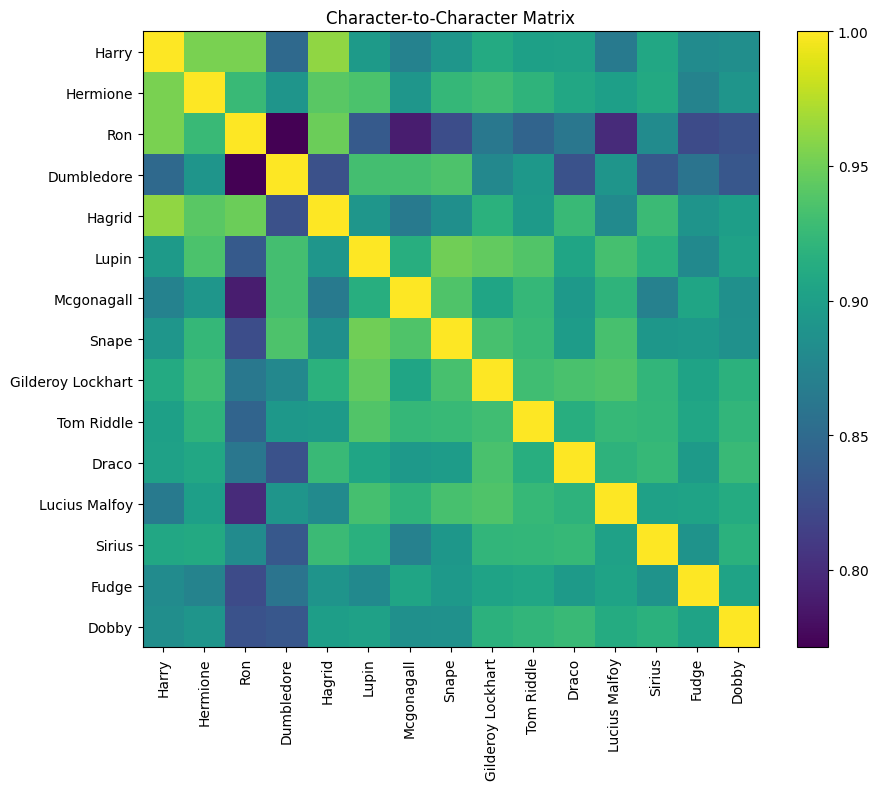

In [81]:
#Plot the matrix
CharacterToCharacterMatrixPlot(combined_sentences_50_most_vocabulary['Character'], histword_similarity_df)